# Notebook 2: Data Preparation & Validation Split

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Paths
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

TRAIN_FEATURES_CSV = DATA_DIR / "train_features.csv"
TRAIN_LABELS_CSV = DATA_DIR / "train_labels.csv"

# Validation split ratio
VAL_SPLIT = 0.2  # 20% of sites for validation

# Class names
CLASS_COLUMNS = [
    'antelope_duiker', 'bird', 'blank', 'civet_genet',
    'hog', 'leopard', 'monkey_prosimian', 'rodent'
]

print(f" Validation split: {VAL_SPLIT*100}% of sites")
print(f" Random seed: {RANDOM_SEED}")

 Validation split: 20.0% of sites
 Random seed: 42


In [3]:
# Load data
train_features = pd.read_csv(TRAIN_FEATURES_CSV)
train_labels = pd.read_csv(TRAIN_LABELS_CSV)

# Merge features and labels
train_data = train_features.merge(train_labels, on='id')

print(f" Loaded {len(train_data)} training images")
print(f" Columns: {list(train_data.columns)}")
print(f"\nData shape: {train_data.shape}")
display(train_data.head())

 Loaded 16488 training images
 Columns: ['id', 'filepath', 'site', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

Data shape: (16488, 11)


,id,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,train_features/ZJ000000.jpg,S0120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,train_features/ZJ000001.jpg,S0069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,train_features/ZJ000002.jpg,S0009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,train_features/ZJ000003.jpg,S0008,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,train_features/ZJ000004.jpg,S0036,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
def create_site_split(train_data, val_ratio=0.2, random_state=42):
    """
    Split sites into train and validation ensuring:
    1. No site overlap
    2. Balanced class distribution
    3. Similar number of images
    """
    
    # Get site information with class distribution
    site_info = []
    for site in train_data['site'].unique():
        site_data = train_data[train_data['site'] == site]
        site_dict = {
            'site': site,
            'n_images': len(site_data)
        }
        # Add class distribution for this site
        for class_name in CLASS_COLUMNS:
            site_dict[class_name] = site_data[class_name].sum()
        site_info.append(site_dict)
    
    site_df = pd.DataFrame(site_info)
    
    # Calculate dominant class for each site (for stratification)
    class_cols_only = [col for col in site_df.columns if col in CLASS_COLUMNS]
    site_df['dominant_class'] = site_df[class_cols_only].idxmax(axis=1)
    
    # Sort sites by number of images
    site_df = site_df.sort_values('n_images', ascending=False)
    
    print(f"Total unique sites: {len(site_df)}")
    print(f"\nSite info preview:")
    display(site_df.head())
    
    # Try to stratify by dominant class to ensure class balance
    try:
        train_sites, val_sites = train_test_split(
            site_df['site'].values,
            test_size=val_ratio,
            random_state=random_state,
            stratify=site_df['dominant_class'].values
        )
        print(" Used stratified split by dominant class")
    except:
        # If stratification fails, do random split
        print(" Stratification failed, using random split")
        train_sites, val_sites = train_test_split(
            site_df['site'].values,
            test_size=val_ratio,
            random_state=random_state
        )
    
    return train_sites, val_sites, site_df

# Create the split
print("="*80)
print("CREATING SITE-BASED TRAIN/VALIDATION SPLIT")
print("="*80 + "\n")

train_sites, val_sites, site_info = create_site_split(train_data, VAL_SPLIT, RANDOM_SEED)

CREATING SITE-BASED TRAIN/VALIDATION SPLIT

Total unique sites: 148

Site info preview:


,site,n_images,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,dominant_class
6,S0060,1132,59.0,0.0,23.0,959.0,20.0,0.0,49.0,22.0,civet_genet
2,S0009,664,33.0,155.0,57.0,16.0,188.0,0.0,190.0,25.0,monkey_prosimian
24,S0063,557,314.0,22.0,44.0,10.0,12.0,0.0,73.0,82.0,antelope_duiker
3,S0008,541,8.0,124.0,40.0,73.0,0.0,0.0,52.0,244.0,rodent
4,S0036,456,45.0,6.0,35.0,14.0,7.0,109.0,134.0,106.0,monkey_prosimian


 Used stratified split by dominant class


In [5]:
# Create train and validation dataframes
train_df = train_data[train_data['site'].isin(train_sites)].copy()
val_df = train_data[train_data['site'].isin(val_sites)].copy()

print(f"\n Train sites: {len(train_sites)}")
print(f" Validation sites: {len(val_sites)}")
print(f"\n Train images: {len(train_df)} ({len(train_df)/len(train_data)*100:.1f}%)")
print(f" Validation images: {len(val_df)} ({len(val_df)/len(train_data)*100:.1f}%)")

# CRITICAL: Verify no overlap
site_overlap = set(train_sites) & set(val_sites)
assert len(site_overlap) == 0, "ERROR: Site overlap detected!"
print("\n Verified: No site overlap between train and validation!")


 Train sites: 118
 Validation sites: 30

 Train images: 13518 (82.0%)
 Validation images: 2970 (18.0%)

 Verified: No site overlap between train and validation!


In [6]:
def get_class_distribution(df, split_name):
    """Get class distribution for a dataframe"""
    dist = {}
    for class_name in CLASS_COLUMNS:
        dist[class_name] = df[class_name].sum()
    return pd.Series(dist, name=split_name)

train_dist = get_class_distribution(train_df, 'train')
val_dist = get_class_distribution(val_df, 'val')
total_dist = get_class_distribution(train_data, 'total')

# Create comparison dataframe
dist_comparison = pd.DataFrame({
    'Total': total_dist,
    'Train': train_dist,
    'Val': val_dist,
    'Train %': (train_dist / total_dist * 100).round(1),
    'Val %': (val_dist / total_dist * 100).round(1)
})

print("="*80)
print("CLASS DISTRIBUTION COMPARISON")
print("="*80)
display(dist_comparison)

CLASS DISTRIBUTION COMPARISON


,Total,Train,Val,Train %,Val %
antelope_duiker,2474.0,2033.0,441.0,82.2,17.8
bird,1641.0,1440.0,201.0,87.8,12.2
blank,2213.0,1839.0,374.0,83.1,16.9
civet_genet,2423.0,2128.0,295.0,87.8,12.2
hog,978.0,891.0,87.0,91.1,8.9
leopard,2254.0,1666.0,588.0,73.9,26.1
monkey_prosimian,2492.0,1937.0,555.0,77.7,22.3
rodent,2013.0,1584.0,429.0,78.7,21.3


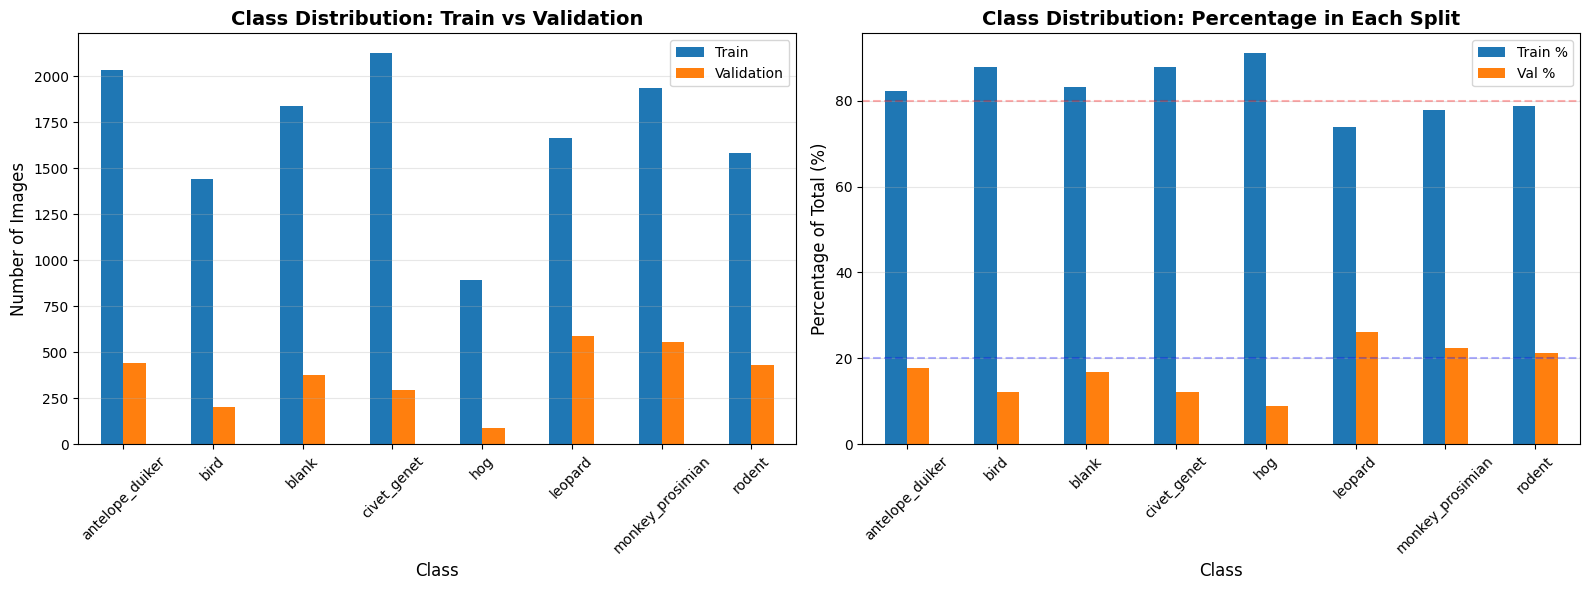

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
dist_comparison[['Train', 'Val']].plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('Class Distribution: Train vs Validation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.legend(['Train', 'Validation'])
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Percentage comparison
dist_comparison[['Train %', 'Val %']].plot(kind='bar', ax=ax2)
ax2.set_title('Class Distribution: Percentage in Each Split', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Percentage of Total (%)', fontsize=12)
ax2.legend(['Train %', 'Val %'])
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=80, color='r', linestyle='--', alpha=0.3)
ax2.axhline(y=20, color='b', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visualizations" / "train_val_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def calculate_class_weights(df, class_columns):
    """
    Calculate class weights for balanced training
    Formula: weight = n_samples / (n_classes * n_samples_class)
    """
    n_samples = len(df)
    n_classes = len(class_columns)
    
    weights = {}
    for class_name in class_columns:
        n_class_samples = df[class_name].sum()
        if n_class_samples > 0:
            weight = n_samples / (n_classes * n_class_samples)
            weights[class_name] = weight
        else:
            weights[class_name] = 1.0
    
    return weights

# Calculate weights based on training set
class_weights = calculate_class_weights(train_df, CLASS_COLUMNS)

print("="*80)
print("CLASS WEIGHTS FOR TRAINING")
print("="*80)

weights_df = pd.DataFrame.from_dict(class_weights, orient='index', columns=['Weight'])
weights_df = weights_df.sort_values('Weight', ascending=False)
display(weights_df)

CLASS WEIGHTS FOR TRAINING


,Weight
hog,1.896465
bird,1.173437
rodent,1.066761
leopard,1.014256
blank,0.918842
monkey_prosimian,0.872354
antelope_duiker,0.831161
civet_genet,0.794055


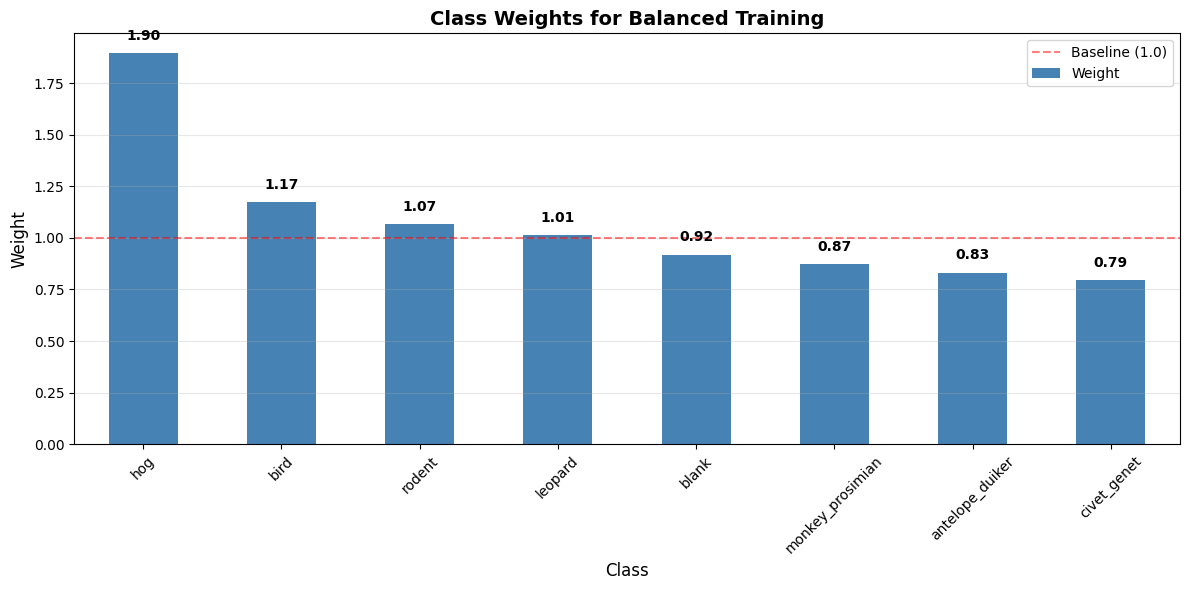

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

weights_df.plot(kind='bar', ax=ax, color='steelblue', legend=False)
ax.set_title('Class Weights for Balanced Training', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Baseline (1.0)')
ax.legend()

# Add value labels
for i, v in enumerate(weights_df['Weight']):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visualizations" / "class_weights.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Save split information
split_info = {
    'train_sites': train_sites.tolist(),
    'val_sites': val_sites.tolist(),
    'n_train_sites': len(train_sites),
    'n_val_sites': len(val_sites),
    'n_train_images': len(train_df),
    'n_val_images': len(val_df),
    'val_split_ratio': VAL_SPLIT,
    'random_seed': RANDOM_SEED,
    'class_weights': class_weights
}

with open(OUTPUT_DIR / 'split_info.json', 'w') as f:
    json.dump(split_info, f, indent=2)

# Save train and val dataframes
train_df.to_csv(OUTPUT_DIR / 'train_split.csv', index=False)
val_df.to_csv(OUTPUT_DIR / 'val_split.csv', index=False)

print(" Split info saved to:", OUTPUT_DIR / 'split_info.json')
print(" Train split saved to:", OUTPUT_DIR / 'train_split.csv')
print(" Validation split saved to:", OUTPUT_DIR / 'val_split.csv')

 Split info saved to: outputs/split_info.json
 Train split saved to: outputs/train_split.csv
 Validation split saved to: outputs/val_split.csv


In [11]:
print("="*80)
print("VALIDATION CHECKS")
print("="*80)

checks = []

# Check 1: No site overlap
site_overlap = set(train_sites) & set(val_sites)
check1 = len(site_overlap) == 0
checks.append(('No site overlap', check1))
print(f"\n{'+' if check1 else '-'} No site overlap: {check1}")

# Check 2: Reasonable split ratio
actual_val_ratio = len(val_df) / len(train_data)
check2 = 0.15 <= actual_val_ratio <= 0.25
checks.append(('Validation ratio (15-25%)', check2))
print(f"{'+' if check2 else '-'} Validation ratio: {actual_val_ratio:.1%} (target: {VAL_SPLIT:.1%})")

# Check 3: All classes represented in both splits
train_classes = set(train_dist[train_dist > 0].index)
val_classes = set(val_dist[val_dist > 0].index)
check3 = len(train_classes) == len(CLASS_COLUMNS) and len(val_classes) == len(CLASS_COLUMNS)
checks.append(('All classes in both splits', check3))
print(f"{'+' if check3 else '-'} All classes in both splits: {check3}")

if not check3:
    missing_train = set(CLASS_COLUMNS) - train_classes
    missing_val = set(CLASS_COLUMNS) - val_classes
    if missing_train:
        print(f"   Missing from train: {missing_train}")
    if missing_val:
        print(f"   Missing from val: {missing_val}")

# Check 4: No ID overlap
check4 = len(set(train_df['id']) & set(val_df['id'])) == 0
checks.append(('No ID overlap', check4))
print(f"{'+' if check4 else '-'} No ID overlap: {check4}")

all_passed = all([c[1] for c in checks])

print("\n" + "="*80)
if all_passed:
    print(" ALL VALIDATION CHECKS PASSED!")
else:
    print(" SOME VALIDATION CHECKS FAILED - REVIEW ABOVE")
print("="*80)

VALIDATION CHECKS

+ No site overlap: True
+ Validation ratio: 18.0% (target: 20.0%)
+ All classes in both splits: True
+ No ID overlap: True

 ALL VALIDATION CHECKS PASSED!


In [12]:
print("="*80)
print("DATA PREPARATION COMPLETE!")
print("="*80)

print("\n Generated Files:")
print(f"   • {OUTPUT_DIR / 'split_info.json'} - Split configuration")
print(f"   • {OUTPUT_DIR / 'train_split.csv'} - Training data")
print(f"   • {OUTPUT_DIR / 'val_split.csv'} - Validation data")

print("\n Key Metrics:")
print(f"   • Training images: {len(train_df):,}")
print(f"   • Validation images: {len(val_df):,}")
print(f"   • Training sites: {len(train_sites)}")
print(f"   • Validation sites: {len(val_sites)}")
print(f"   • Class weights calculated: {len(class_weights)}")

DATA PREPARATION COMPLETE!

 Generated Files:
   • outputs/split_info.json - Split configuration
   • outputs/train_split.csv - Training data
   • outputs/val_split.csv - Validation data

 Key Metrics:
   • Training images: 13,518
   • Validation images: 2,970
   • Training sites: 118
   • Validation sites: 30
   • Class weights calculated: 8
